**목표**  
부동산 경매 정보를 바탕으로 물건의 낙찰가를 예측 하고,  
투자자금을 설정하여, 그 금액에 맞는 최고 이익률을 낼 수 있는 상품을 추천하는 것이 목적이다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium

import warnings
import os

warnings.filterwarnings(action='ignore')

In [2]:
address_ = '../../../DataSet/codestates/project2/'

6개의 파일로 구성 되어 있으며 df_1로 학습을 진행하고, df_2 ~ df_4의 데이터로 보정을 한다.  
목적은 경매데이터를 바탕으로 물건의 적정경매가를 산정하고, 개별 보유자금(Threshold)를 기준으로 상위 10개의 상품을 추천하는 서비스를 제공  

In [3]:
for i, file in enumerate(os.listdir(address_)):
    globals()['df_'+str(i)] = pd.read_csv(address_+file)
    print('df_'+str(i)+' : '+ file)
    print(f'')

df_0 : Auction_master_test.csv

df_1 : Auction_master_train.csv

df_2 : Auction_regist.csv

df_3 : Auction_rent.csv

df_4 : Auction_result.csv

df_5 : Auction_submission.csv



In [72]:
(df_1.shape, df_0.shape)

((1933, 41), (829, 41))

Auction_key = 경매 아파트 고유 키값  
Auction_class = 경매구분 강제경매 : 법원에 소송을 제기하여 판결을 얻은 후 집행권원에 따라 경매를 진행 임의경매 : 등기부등본 담보권(저당권, 가압류등)으로 경매를 진행  
Bid_class = 입찰구분(일반/개별/일괄)  
Claim_price = 경매 신청인의 청구 금액  
Appraisal_company = 감정사  
Appraisal_date = 감정일자  
Auction_count = 총경매횟수  
Auction_miscarriage_count = 총유찰횟수  
Total_land_gross_area = 총토지전체면적(㎡)  
Total_land_real_area = 총토지실면적(㎡)  
Total_land_auction_area = 총토지경매면적(㎡)  
Total_building_area = 총건물면적(㎡)  
Total_building_auction_area = 총건물경매면적(㎡)  
Total_appraisal_price = 총감정가  
Minimum_sales_price = 최저매각가격, 입찰 시 입찰인이 최저로 제시해야만 하는 금액  
First_auction_date = 최초경매일  
Final_auction_date = 최종경매일  
Final_result = 최종결과  
Creditor = 채권자, 경매 신청인  
addr_do = 주소_시도  
addr_si = 주소_시군구  
addr_dong = 주소_읍면동  
addr_li = 주소_리  
addr_san = 주소_산번지 여부(Y/N)  
addr_bunji1 = 주소_번지1  
addr_bunji2 = 주소_번지2  
addr_etc = 주소_기타주소  
Apartment_usage = 건물(토지)의 대표 용도  
Completion_date = 준공일  
Preserve_regist_date = 보존등기일, 건물을 신축하고 처음으로 등기  
Total_floor = 총층수  
Current_floor = 현재층수  
Specific = 기타_특이사항  
Share_auction_YorN = 지분경매 여부(Y/N), 하나의 부동산이 전체가 아닌 일부만 경매가 진행 (하나의 부동산의 공유자가 지분으로 소유권을 가지고 있을 때 그중 일부 지분만 경매가 진행)  
road_name = 도로명주소_도로명  
road_bunji1 = 도로명주소_번지1  
road_bunji2 = 도로명주소_번지2  
Close_date = 종국일자  
Close_result = 종국결과, 낙찰과 배당의 차이 : 경매 진행은 ①경매진행(낙찰) ▷ ②낙찰허가결정 ▷ ③대금납부 ▷ ④배당 후 종결 로 이뤄집니다. 낙찰자가 최고가로 입찰(①)해서 낙찰허가(②)를 받으면 대금납부기한 낙찰금을 입금(③)합니다. 법원은 납부된 낙찰금을 가지고 채권자에게 순위에 의한 배당(④)을 해주고 경매는 종결됩니다.  
point.y = 위도  
point.x = 경도  
Hammer_price = 낙찰가

1. EDA

In [4]:
pd.set_option('display.max_columns', None)
df_1.corr()['Hammer_price'].sort_values(ascending=False)

# Minimum_sales_price(최저매각가격)와 Total_appraisal_price(총감정가)은 낙찰가와 너무 높은 상관관계를 보여서 다르게 처리를 해야 할 필요성이 존재함
# Auction Key는 PK로 활용 하는 것이기 때문에 다른 의미가 없음

Hammer_price                   1.000000
Minimum_sales_price            0.994592
Total_appraisal_price          0.953464
Total_building_auction_area    0.772839
Total_building_area            0.768454
Total_land_auction_area        0.700639
Total_land_real_area           0.696099
point.y                        0.295698
Claim_price                    0.267728
Total_floor                    0.220830
road_bunji2                    0.206681
Current_floor                  0.198013
Total_land_gross_area          0.070466
road_bunji1                    0.020404
addr_bunji1                   -0.003139
addr_bunji2                   -0.003641
Auction_miscarriage_count     -0.011296
Auction_count                 -0.016999
point.x                       -0.296312
Auction_key                   -0.418769
Name: Hammer_price, dtype: float64

<AxesSubplot:>

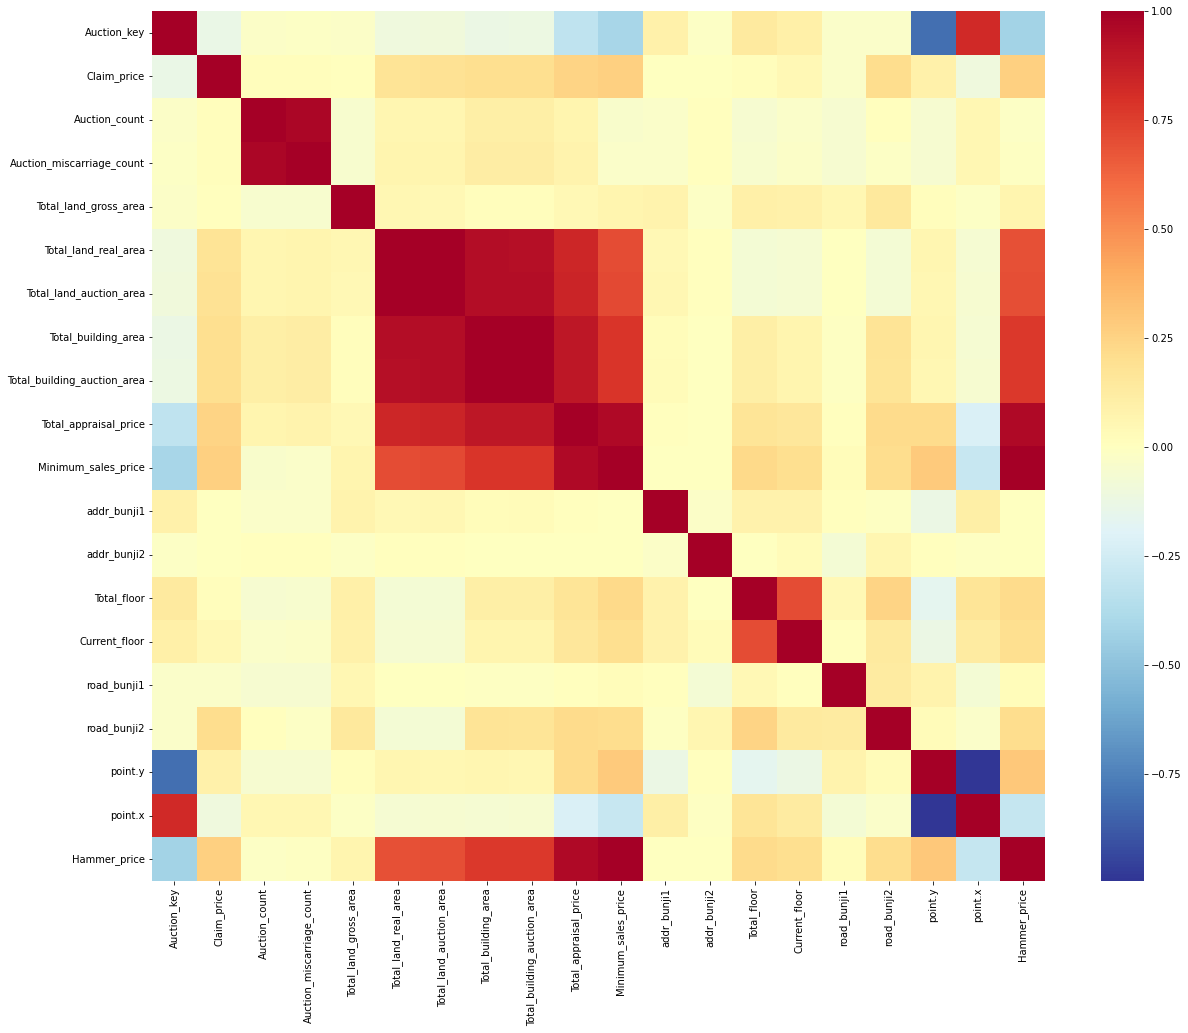

In [5]:
plt.figure(figsize=(20,16))
sns.heatmap(df_1.corr(), cmap='RdYlBu_r')
# point x, y 위 경도 이기 때문에 관계성 가능
# Auction_count와 Auction_miscarriage_count 관계 높은것은 당연(유찰수가 많아지면 경매수가 많아짐.)
# Total area 역시 정리가 필요
# Total Floor가 크면 Current_Floor도 높아질 가능성이 높음
# 날짜 데이터 정리 

In [6]:
# df_1 Null Check
df_1.isna().sum().sort_values(ascending=False)[df_1.isna().sum().sort_values(ascending=False) != 0]

addr_li        1910
Specific       1869
road_bunji2    1778
addr_bunji2    1044
road_bunji1      24
addr_bunji1       4
dtype: int64

In [7]:
df_1.dtypes[df_1.dtypes=='object'] # 범주형 데이터 정리 

Auction_class           object
Bid_class               object
Appraisal_company       object
Appraisal_date          object
First_auction_date      object
Final_auction_date      object
Final_result            object
Creditor                object
addr_do                 object
addr_si                 object
addr_dong               object
addr_li                 object
addr_san                object
addr_etc                object
Apartment_usage         object
Preserve_regist_date    object
Specific                object
Share_auction_YorN      object
road_name               object
Close_date              object
Close_result            object
dtype: object

In [8]:
# df_1[df_1['Close_result']=='    ']
df_1.loc[df_1['Close_date'] == '1111-11-11 00:00:00']['Close_date']

962     1111-11-11 00:00:00
1016    1111-11-11 00:00:00
1026    1111-11-11 00:00:00
1040    1111-11-11 00:00:00
1146    1111-11-11 00:00:00
1407    1111-11-11 00:00:00
1438    1111-11-11 00:00:00
1627    1111-11-11 00:00:00
1640    1111-11-11 00:00:00
1665    1111-11-11 00:00:00
1867    1111-11-11 00:00:00
1924    1111-11-11 00:00:00
Name: Close_date, dtype: object

In [9]:
df_1['Final_result'].unique()

array(['낙찰'], dtype=object)

2. Feature Engineering

In [10]:
# 또한 부동산 가격은 단위가 억단위 이기 때문에 보다 정밀한 연산을 하기 위해서는 단위를 바꿀 필요가 있다
# 낙찰가 / 최저매각가격 를 통해 최저매각대비 얼마상승된 금액으로 구매했느냐로 하면 최저매각가격의 문제를 해결 할 수 있을 것으로 보임
# 1 - 최저매각가격 / 총감정가 를 통해 최초할인율로 변경하여 총감정가의 문제도 해결 될 것으로 보임
# 단 서비스 운영 시, target(낙찰가)값을 없을 수 있기 때문에 고려를 해놓아야 함 (낙찰가를 아는 것이 목표이기 때문)
# 예상상승률 = 현재 주위의 시가 / 낙찰가 로 계산하여 이용하면 가능
# 최종경매일 - 최초경매일 = 경매기간으로 정리

def column_parsing(df):
    df_copy = df.copy()
    from sklearn.decomposition import PCA

    #날짜 처리
    del_dates = ['Final_auction_date', 'First_auction_date', 'Appraisal_date' ,'Preserve_regist_date', 'Close_date']
    df_copy['Auction_period'] = pd.to_datetime(df_copy['Final_auction_date']) - pd.to_datetime(df_copy['First_auction_date'])
    df_copy['Auction_period'] = df_copy['Auction_period'].dt.days
    df_copy['Appraisal_date'] = pd.to_datetime(df_copy['Appraisal_date'])
    df_copy.loc[df_copy['Close_date'] == '1111-11-11 00:00:00', 'Close_date'] = df_copy['Close_date'].max()
    df_copy['F_Appraisal_T_Close'] = pd.to_datetime(df_copy['Close_date']) - pd.to_datetime(df_copy['Appraisal_date'])
    df_copy['F_Appraisal_T_Close'] = df_copy['F_Appraisal_T_Close'].dt.days

    # target값 변경
    df_copy['Premium_ratio'] = (df_copy['Hammer_price'] / df_copy['Minimum_sales_price']).astype('float64')
    df_copy['Discount_ratio'] = (1 - df_copy['Minimum_sales_price'] / df_copy['Total_appraisal_price']).astype('float64')

    # 결측치 처리
    df_copy['addr_li'] = df_copy['addr_li'].fillna('')
    df_copy['addr_bunji1'] = df_copy['addr_bunji1'].fillna(0)
    df_copy['addr_bunji2'] = df_copy['addr_bunji2'].fillna(0)
    df_copy['road_bunji1'] = df_copy['road_bunji1'].fillna(0)
    df_copy['road_bunji2'] = df_copy['road_bunji2'].fillna(0)

    # Object 타입 정리
    # 감정평가사에 따라 시세가 달라지지 않을 것 같으므로 제거
    del_columns = ['Appraisal_company','Final_result','Creditor']

    # 높은 상관관계도를 가지는 Columns들 정리(PCA를 통해 차원을 낮춤)
    highly_corr = ['Total_land_real_area', 'Total_land_auction_area', 'Total_building_area', 'Total_building_auction_area', 'Total_appraisal_price', 'Minimum_sales_price']
    pca = PCA(n_components=1)
    pca.fit(df.loc[:, highly_corr])
    df_copy['PCA_area_price'] = pca.transform(df_copy.loc[:, highly_corr])

    df_copy.drop(columns=['Hammer_price','Auction_miscarriage_count','Total_floor'],inplace=True)
    df_copy.drop(columns=highly_corr, inplace=True)
    df_copy.drop(columns=del_dates, inplace=True)
    df_copy.drop(columns=del_columns, inplace=True)
    df_copy.drop(columns=['point.x','point.y'])

    return df_copy

In [11]:
df0 = column_parsing(df_0)
df1 = column_parsing(df_1)

df1.corr()['Premium_ratio'].sort_values(ascending=False)


Premium_ratio            1.000000
Discount_ratio           0.468699
Auction_count            0.354610
Auction_period           0.187669
F_Appraisal_T_Close      0.147333
Claim_price              0.100713
road_bunji2              0.054253
point.y                  0.038030
addr_bunji1              0.012428
Total_land_gross_area    0.007116
PCA_area_price          -0.013037
addr_bunji2             -0.017019
road_bunji1             -0.025065
point.x                 -0.039228
Current_floor           -0.055320
Auction_key             -0.062281
Name: Premium_ratio, dtype: float64

In [12]:
df1['Bid_class'].unique()

array(['개별', '일반', '일괄'], dtype=object)

<AxesSubplot:xlabel='Bid_class', ylabel='Premium_ratio'>

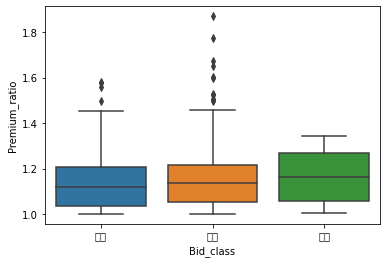

In [13]:
sns.boxplot(x='Bid_class', y='Premium_ratio', data=df1)

<AxesSubplot:>

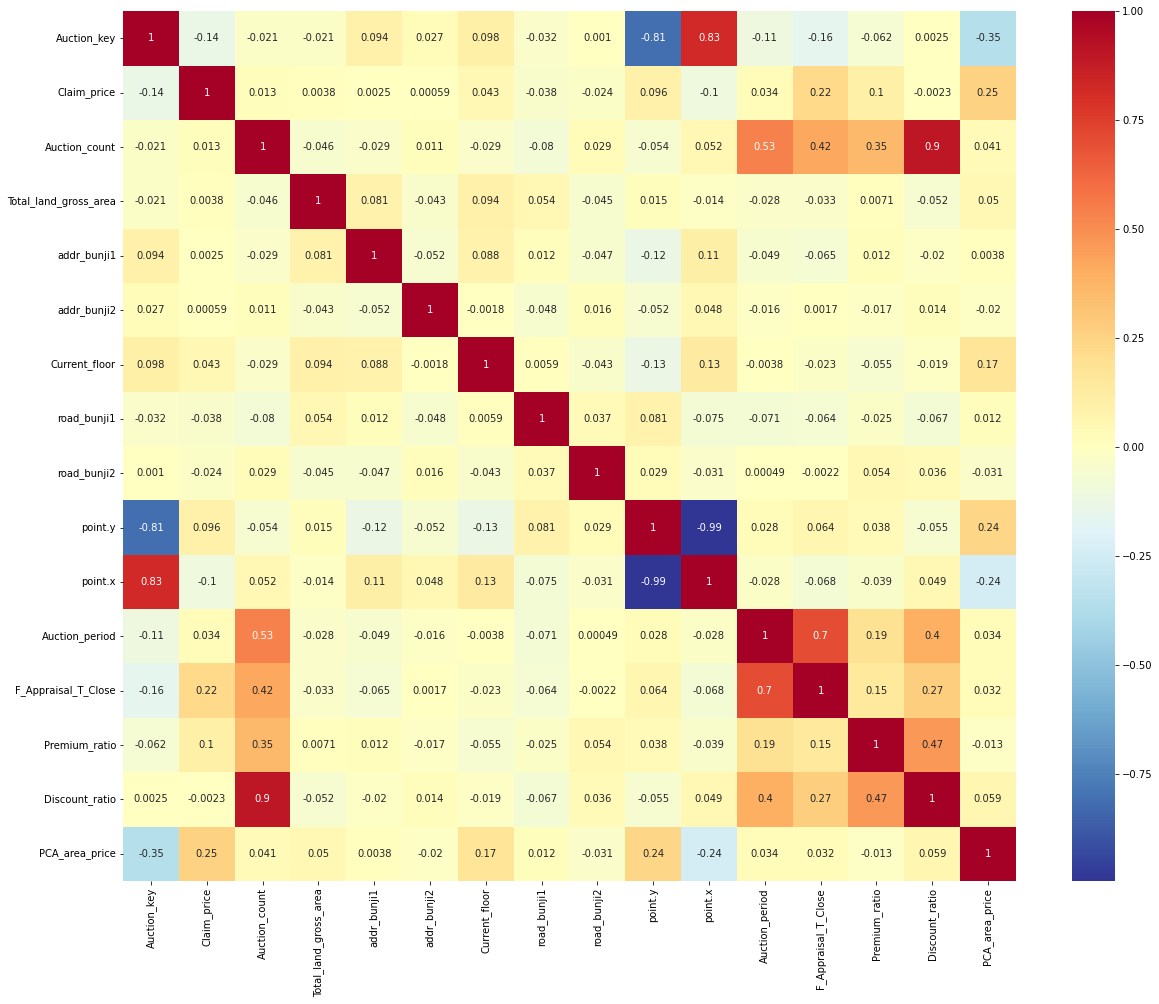

In [14]:
plt.figure(figsize=(20,16))
sns.heatmap(df1.corr(), cmap='RdYlBu_r', annot=True)

3. Data Split

In [15]:
from sklearn.model_selection import train_test_split


pd.options.display.max_columns = 20

def train_test_Split(df, size):
    train, test = train_test_split(df, train_size=size)
    return train, test

def feature_Split(df,target): #df_1, df_2 가능
    features = df.columns.drop([target])
    X = df[features]
    y = df[target]
    return X, y

In [16]:
train, val = train_test_Split(df1, 0.8)
X_test, y_test = feature_Split(df0,'Premium_ratio')
df1_X, df1_y = feature_Split(train,'Premium_ratio')
df0_X, df0_y = feature_Split(val,'Premium_ratio')

4. Modeling  
Baseline = Linear Regression  
Model = XGBoosting, Randomforest, Ridge

In [17]:
from category_encoders import OrdinalEncoder,CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from scipy.stats import randint

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline

In [18]:

from sklearn.model_selection import RandomizedSearchCV


Baseline_pipe1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LinearRegression(n_jobs=-1)
)

model_pipe1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    Ridge(alpha=0.23, normalize=True)
)

model_pipe2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, max_depth=6, criterion='squared_error',max_features='sqrt',max_leaf_nodes=20, random_state=77)
)

model_pipe3 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(n_jobs=-1, random_state=77)
)

In [19]:
Baseline_pipe1.fit(df1_X, df1_y)
df0_pred_1 = Baseline_pipe1.predict(df0_X)
test_pred_1 = Baseline_pipe1.predict(X_test)
rmse = mean_squared_error(df0_y, df0_pred_1) ** 0.5
mae = mean_absolute_error(df0_y, df0_pred_1)
test_hammer1 = test_pred_1 * df_0['Minimum_sales_price']
print('Baseline1(1차) - [RMSE : ',rmse,'] , [MAE : ', mae,']')
print('평균 예상 낙찰가 : ', test_hammer1[1])
print()

dists={ 
    'ridge__alpha' : np.arange(0.01, 10, 0.05),
    'ridge__solver' : ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga','lbfgs']
}
clf1 = RandomizedSearchCV(
    model_pipe1,
    param_distributions=dists,
    n_iter=5,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
clf1.fit(df1_X, df1_y)
df0_pred_2 = clf1.predict(df0_X)
test_pred_2 = clf1.predict(X_test)
rmse = mean_squared_error(df0_y, df0_pred_2) ** 0.5
mae = mean_absolute_error(df0_y, df0_pred_2)
test_hammer2 = test_pred_2 * df_0['Minimum_sales_price']
print('Ridge - [RMSE : ',rmse,'] , [MAE : ', mae,']')
print("Optimal Hyperparameter:", clf1.best_params_)
print("Score:", clf1.best_score_)
print('평균 예상 낙찰가 : ', test_hammer2[1])
print()

dists={ 
    'randomforestregressor__criterion' : ['squared_error', 'absolute_error','poisson'],
    'randomforestregressor__max_features' : ['sqrt','log2',None],
    'randomforestregressor__n_estimators' : randint(50, 500),
    'randomforestregressor__max_depth' : range(5, 10),
    'randomforestregressor__max_leaf_nodes' : range(10,100)
}
clf2 = RandomizedSearchCV(
    model_pipe2,
    param_distributions=dists,
    n_iter=5,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
clf2.fit(df1_X, df1_y)
df0_pred_3 = clf2.predict(df0_X)
test_pred_3 = clf2.predict(X_test)
rmse = mean_squared_error(df0_y, df0_pred_3) ** 0.5
mae = mean_absolute_error(df0_y, df0_pred_3)
test_hammer3 = test_pred_3 * df_0['Minimum_sales_price']
print('RandomForest - [RMSE : ',rmse,'] , [MAE : ', mae,']')
print("Optimal Hyperparameter:", clf2.best_params_)
print("Score:", clf2.best_score_)
print('평균 예상 낙찰가 : ', test_hammer3[1])
print()


dists={ 
    'xgbregressor__learning_rate' : np.arange(0.1, 0.7, 0.02),
    'xgbregressor__n_estimators' : randint(50, 500),
    'xgbregressor__max_depth' : range(5, 10),
    'xgbregressor__lambda' : np.arange(0.1, 10, 0.05),
    'xgbregressor__subsample' : np.arange(0.1, 1, 0.01)
}
clf3 = RandomizedSearchCV(
    model_pipe3,
    param_distributions=dists,
    n_iter=5,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
clf3.fit(df1_X, df1_y)
df0_pred_4 = clf3.predict(df0_X)
test_pred_4 = clf3.predict(X_test)
rmse = mean_squared_error(df0_y, df0_pred_4) ** 0.5
mae = mean_absolute_error(df0_y, df0_pred_4)
test_hammer4 = test_pred_4 * df_0['Minimum_sales_price']
print('XGB - [RMSE : ',rmse,'] , [MAE : ', mae,']')
print("Optimal Hyperparameter:", clf3.best_params_)
print("Score:", clf3.best_score_)
print('평균 예상 낙찰가 : ', test_hammer4[1])
print()

#1차 663968228.081394 467125092.8289221


Baseline1(1차) - [RMSE :  0.09171017855065154 ] , [MAE :  0.06669256856588221 ]
평균 예상 낙찰가 :  145526205.92791426

Ridge - [RMSE :  0.09637891808969572 ] , [MAE :  0.07732341941301045 ]
Optimal Hyperparameter: {'ridge__solver': 'auto', 'ridge__alpha': 1.26}
Score: -0.09593671259523055
평균 예상 낙찰가 :  146624014.46009547

RandomForest - [RMSE :  0.08731252645034822 ] , [MAE :  0.06235522761312069 ]
Optimal Hyperparameter: {'randomforestregressor__criterion': 'absolute_error', 'randomforestregressor__max_depth': 6, 'randomforestregressor__max_features': None, 'randomforestregressor__max_leaf_nodes': 39, 'randomforestregressor__n_estimators': 88}
Score: -0.08828857334644573
평균 예상 낙찰가 :  132893982.60357493

XGB - [RMSE :  0.09072879825892609 ] , [MAE :  0.06721805716148627 ]
Optimal Hyperparameter: {'xgbregressor__lambda': 5.050000000000002, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 374, 'xgbregressor__subsample': 0.8099999999999996}
Score: -0

In [20]:
# ELI5를 이용한 PermutationImportance 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

encoder = OrdinalEncoder()
imputer = SimpleImputer()

A0 = encoder.fit_transform(df0_X)
B0 = imputer.fit_transform(A0)
A1 = encoder.fit_transform(df1_X)
B1 = imputer.fit_transform(A1)

permuter = PermutationImportance(
    clf2.best_estimator_, 
    scoring='neg_root_mean_squared_error', 
    n_iter=5,
    random_state=2
)

permuter.fit(A0, df0_y)
feature_names = A0.columns.tolist()

eli5.show_weights(
    permuter,
    top=15,
    feature_names = feature_names
)

# Target에 대한 Feature의 Weight는 discount_ratio / auction_count / auction_period  등이 높은중요도로 표현 되었다. 
# 이는 Feature의 유무에 따른 영향도 이기에, 해당 Feature가 Target에 대한변화량이라고 보아도 무방하다.

Weight,Feature
0.0284 ± 0.0032,Discount_ratio
0.0018 ± 0.0012,F_Appraisal_T_Close
0.0016 ± 0.0005,Total_land_gross_area
0.0008 ± 0.0003,Auction_key
0.0007 ± 0.0006,PCA_area_price
0.0005 ± 0.0003,Auction_period
0.0003 ± 0.0004,point.x
0.0002 ± 0.0002,Current_floor
0.0002 ± 0.0003,point.y
0.0000 ± 0.0003,addr_bunji2


**낙찰가에 따른 최고 수익률 물건 추천**

In [60]:
result = (test_hammer3 + test_hammer4)/2
df_0['Hammer_price'] = result

In [22]:
My_Capital = 100000000

감정가액-예상낙찰가액(자본금에 따른) = 예상수익금액
782    2.319395e+08
457    2.051431e+08
20     1.282075e+08
1      9.938403e+07
297    4.785054e+07
138    3.625428e+07
284    3.284758e+07
128    3.242625e+07
17     3.165238e+07
592    2.767353e+07
dtype: float64

예상 낙찰가 상위 10개
782    1.110605e+08
457    1.008569e+08
20     3.379253e+07
1      1.293616e+08
297    5.314946e+07
138    1.157457e+08
284    5.415242e+07
128    1.275737e+08
17     1.053476e+08
592    1.073265e+08
Name: Minimum_sales_price, dtype: float64


<AxesSubplot:xlabel='Dataframe Index', ylabel='Net Profit'>

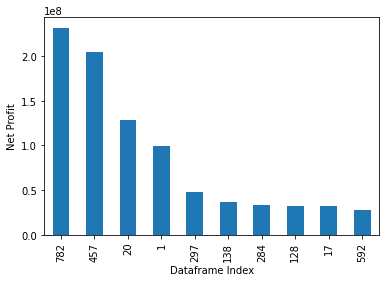

In [73]:
# 자기 자본의 130% 값 이하의 예상 낙찰금액 물건 중 감정가까지의 실수익이 큰 상위 10개를 출력
from matplotlib.pyplot import xlabel, ylabel

print('감정가액-예상낙찰가액(자본금에 따른) = 예상수익금액')
print((df_0['Total_appraisal_price']-result[result< My_Capital*1.3]).sort_values(ascending=False).head(10))

print('\n예상 낙찰가 상위 10개')
print(result.loc[(df_0['Total_appraisal_price']-result[result< My_Capital*1.3]).sort_values(ascending=False).index].head(10))
(df_0['Total_appraisal_price']-result[result< My_Capital*1.3]).sort_values(ascending=False).head(10).plot.bar(ylabel='Net Profit', xlabel='Dataframe Index')

In [68]:
# 적정 투자상품 상위 10개 출력
pd.set_option('display.max_columns', None)

df_top10 = df_0.loc[(df_0['Total_appraisal_price']-result[result< My_Capital*1.3]).sort_values(ascending=False).index].head(10).reset_index()
df_top10.drop(columns='index', inplace=True)
df_top10

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Final_result,Creditor,addr_do,addr_si,addr_dong,addr_li,addr_san,addr_bunji1,addr_bunji2,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,1607,임의,일반,16000000,동부감정,2016-07-18 00:00:00,9,6,5752.4,26.26,26.26,84.99,84.99,343000000,89915000,2016-11-28 00:00:00,2017-12-26 00:00:00,낙찰,비엔케이캐피탈,서울,중랑구,묵동,NaN,N,378.0,NaN,한국 101동 6층 605호,아파트,1999-06-07 00:00:00,19,6,NaN,N,중랑천로,332.0,NaN,2018-02-28 00:00:00,배당,37.614388,127.073532,1.110605e+08
1,552,임의,일반,63000000,화인감정,2016-09-08 00:00:00,8,6,550.4,26.33,26.33,67.15,67.15,306000000,80216000,2017-02-13 00:00:00,2017-12-11 00:00:00,낙찰,Private,서울,광진구,구의동,NaN,N,198.0,4.0,광남캐스빌 5층 502호,아파트,2003-02-12 00:00:00,7,5,NaN,N,광나루로54길,13.0,NaN,2018-02-07 00:00:00,배당,37.540113,127.095743,1.008569e+08
2,1852,강제,일반,49213763,나라감정,2015-11-24 00:00:00,7,5,26420.0,26.39,26.39,59.85,59.85,162000000,27227000,2016-05-11 00:00:00,2016-11-23 00:00:00,낙찰,농협은행,부산,사상구,엄궁동,NaN,N,669.0,2.0,엄궁대림 106동 3층 302호,아파트,1999-09-07 00:00:00,25,3,NaN,N,엄궁로,158.0,NaN,2017-01-24 00:00:00,배당,35.129152,128.978231,3.379253e+07
3,1779,강제,개별,1087000000,대한감정,2012-06-11 00:00:00,6,5,532.0,16.65,16.65,98.08,98.08,228745632,117118000,2013-07-04 00:00:00,2016-04-29 00:00:00,낙찰,Private,부산,동래구,낙민동,NaN,N,236.0,NaN,",237-2 삼주 6층 601호",주상복합,1111-11-11 00:00:00,15,6,"**1차감정:220,000,000",N,0,NaN,NaN,2017-06-29 00:00:00,배당,35.201112,129.088687,1.293616e+08
4,3,강제,개별,900000000,신명감정,2016-03-15 00:00:00,5,4,574.0,30.73,8.78,73.07,20.88,101000000,41370000,2011-06-21 00:00:00,2016-10-11 00:00:00,낙찰,푸른이상호저축,서울,동작구,상도동,NaN,N,1.0,38.0,삼부한강 2층 201호,아파트,2005-07-15 00:00:00,9,2,NaN,Y,0,NaN,NaN,1111-11-11 00:00:00,,37.508586,126.953019,5.314946e+07
5,2236,임의,일반,81177855,명신감정,2017-01-05 00:00:00,3,2,4946.0,40.04,40.04,84.97,84.97,152000000,97280000,2017-09-28 00:00:00,2017-12-07 00:00:00,낙찰,부산은행,부산,사하구,괴정동,NaN,N,350.0,72.0,동아파크맨션 12층 1207호,아파트,1992-07-15 00:00:00,12,12,NaN,N,오작로,138.0,NaN,2018-02-26 00:00:00,배당,35.103029,129.004955,1.157457e+08
6,2719,임의,일반,32309480,희감정,2017-05-16 00:00:00,4,3,717.0,27.73,27.73,67.96,67.96,87000000,44544000,2017-10-17 00:00:00,2018-01-23 00:00:00,낙찰,냉동냉장수협,부산,서구,남부민동,NaN,N,677.0,16.0,남양 4층 401호,주상복합,1972-10-23 00:00:00,4,4,NaN,N,남부민로10번길,5.0,NaN,2018-03-28 00:00:00,배당,35.084590,129.024012,5.415242e+07
7,2208,강제,일반,1606290000,희감정,2016-12-22 00:00:00,3,2,889.6,50.36,50.36,68.73,68.73,160000000,102400000,2017-09-28 00:00:00,2017-12-07 00:00:00,낙찰,캐패탈코리아엔젤투자,부산,사하구,하단동,NaN,N,13.0,3.0,",625-3 삼창주택 가동 5층 501호",아파트,1985-01-24 00:00:00,5,5,NaN,N,괴정로57번길,48.0,NaN,2018-02-26 00:00:00,배당,35.102632,128.972853,1.275737e+08
8,1844,강제,개별,1000000000,프라임감정,2015-11-05 00:00:00,4,2,38740.0,61.30,61.30,45.05,45.05,137000000,87680000,2016-06-23 00:00:00,2016-10-20 00:00:00,낙찰,한국군사문제연구원,부산,서구,암남동,NaN,N,255.0,1.0,외16 송도탑스빌 7층 707호,주상복합,2000-07-20 00:00:00,33,7,NaN,N,충무대로,56.0,NaN,2017-02-02 00:00:00,배당,35.077914,129.018121,1.053476e+08
9,1004,임의,일반,74360547,L.H감정,2016-01-04 00:00:00,3,2,1113.5,2.89,2.89,12.04,12.04,135000000,86400000,2016-07-05 00:00:00,2016-09-28 00:00:00,낙찰,하나은행,서울,금천구,가산동,NaN,N,141.0,2.0,", -3, -4, -5, -6, -7, -20 가산양우내안애애플 10층 1006호",아파트,2013-10-08 00:00:00,18,10,NaN,N,남부순환로,1266.0,NaN,2016-12-21 00:00:00,배당,37.478898,126.891155,1.073265e+08


In [69]:
temp_Y = 37.5722440
temp_X = 126.9759352
main_location = (temp_Y, temp_X)

m = folium.Map(
    location=main_location,
    zoom_start = 7
)

for i, coord in enumerate(zip(df_top10['point.y'],df_top10['point.x'])):
    if df_top10['Total_appraisal_price'][i] > df_top10['Hammer_price'][i]*2: #기대 수익률이 100% 이상이면
        color = 'red'
    else: 
        color = 'gray'
    folium.Marker(coord, tooltip=df_top10['addr_etc'][i], icon=folium.Icon(color=color, icon='star')).add_to(m) 

m

In [56]:
df_top10['addr_etc']

782                                  한국 101동 6층 605호
457                                    광남캐스빌 5층 502호
20                                 엄궁대림 106동 3층 302호
1                                  ,237-2 삼주 6층 601호
297                                     삼부한강 2층 201호
138                                 동아파크맨션 12층 1207호
284                                       남양 4층 401호
128                           ,625-3 삼창주택 가동 5층 501호
17                                 외16 송도탑스빌 7층 707호
592    , -3, -4, -5, -6, -7, -20 가산양우내안애애플 10층 1006호
Name: addr_etc, dtype: object